In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import json
from tqdm import tqdm
import os

import nomad.io.base as loader
import nomad.city_gen as cg
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
from nomad.city_gen import City

import nomad.data as data_folder
from pathlib import Path
data_dir = Path(data_folder.__file__).parent
path = data_dir / "garden_city.gpkg"

## Load city and configure destination diaries

In [2]:
# Load the city
city_file = data_dir / "garden-city.gpkg"
city = cg.City.from_geopackage(city_file)
start = '2024-06-01 00:00-04:00'

#option 1: symmetric
start_time = pd.date_range(start=start, periods=4, freq='60min')
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*4  # in minutes
location = ['h-x14-y11'] * 1 + ['h-x14-y9'] * 1 + ['w-x17-y10'] * 1 + ['w-x17-y8'] * 1

destinations = pd.DataFrame(
    {
        "datetime":start_time,
         "timestamp":unix_timestamp,
         "duration":duration,
         "location":location
    }
)
destinations.to_csv("exp_1_destinations_balanced.csv", index=False)

#option 2: we break symmetries to produce more density heterogeneity
start_time = pd.date_range(start=start, periods=8, freq='30min')
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [30]*8 
location = ['h-x14-y11'] * 2 + ['h-x14-y9'] * 1 + ['w-x17-y10'] * 2 + ['w-x17-y8'] * 3

destinations = pd.DataFrame(
    {
        "datetime":start_time,
         "timestamp":unix_timestamp,
         "duration":duration,
         "location":location
    }
)
destinations.to_csv("exp_1_destinations_unbalanced.csv", index=False)

## Config files for simulations
This could be in a json or yaml and should be passable to a Population object.

In [13]:
# option 1 (reduced for quick demo run)
N_reps = 3000
sparsity_samples = 1
config = dict(
    dt = 0.5,
    N = N_reps*sparsity_samples,
    name_count=2,
    name_seed=2025,
    city_file=str(data_dir / "garden-city.gpkg"),
    destination_diary_file='exp_1_destinations_balanced.csv',
    output_files = dict(
        sparse_path='./sparse_traj_1',
        diaries_path='./diaries_1',
        homes_path='./homes_1'
    ),
    agent_params = dict(
        agent_homes='h-x14-y11',
        agent_workplaces='w-x17-y8',
        seed_trajectory=list(range(N_reps*sparsity_samples)),
        seed_sparsity= list(range(N_reps*sparsity_samples)),
        beta_ping= np.repeat(np.linspace(1, 20, sparsity_samples), N_reps).tolist(),
        beta_durations=None,
        beta_start=None,
        ha=11.5/15
    )
)
with open('config_low_ha.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

# option 2 (reduced for quick demo run)
N_reps = 3000
sparsity_samples = 1
config_2 = dict(
    dt = 0.5,
    N = N_reps*sparsity_samples,
    name_count=2,
    name_seed=2025,
    city_file=str(data_dir / "garden-city.gpkg"),
    destination_diary_file='exp_1_destinations_unbalanced.csv',
    output_files = dict(
        sparse_path='./sparse_traj_2',
        diaries_path='./diaries_2',
        homes_path='./homes_2'
    ),
    agent_params = dict(
        agent_homes='h-x14-y11',
        agent_workplaces='w-x17-y8',
        seed_trajectory=list(range(N_reps*sparsity_samples)),
        seed_sparsity= list(range(N_reps*sparsity_samples)),
        beta_ping= np.repeat(np.linspace(1, 20, sparsity_samples), N_reps).tolist(),
        beta_durations=None,
        beta_start=None,
        ha=15/15
    )
)
with open('config_high_ha.json', 'w', encoding='utf-8') as f:
    json.dump(config_2, f, ensure_ascii=False, indent=4)

## Generate trajectories

In [14]:
# Parameters according to the config file
with open('config_high_ha.json', 'r', encoding='utf-8') as f:
    config = json.load(f)
    
# Load city and destination diary from config
city = City.from_geopackage(config["city_file"])
city.compute_gravity(exponent=2.0, use_proxy_hub_distance=False)

# Build POI data from buildings_gdf door info
poi_data = pd.DataFrame({
    'building_id': city.buildings_gdf['id'].values,
    'x': city.buildings_gdf['door_point'].apply(lambda p: p[0]).values,
    'y': city.buildings_gdf['door_point'].apply(lambda p: p[1]).values
})

destinations = pd.read_csv(config["destination_diary_file"], parse_dates=["datetime"])

population = Population(city)
population.generate_agents(
    N=config["N"],
    seed=config["name_seed"], 
    name_count=config["name_count"],
    agent_homes=config["agent_params"]["agent_homes"],
    agent_workplaces=config["agent_params"]["agent_workplaces"]
)

for i, agent in enumerate(tqdm(population.roster.values(), desc="Generating trajectories")):
    agent.generate_trajectory(
        destination_diary=destinations,
        dt=config["dt"],
        seed=config["agent_params"]["seed_trajectory"][i],
        step_seed=config["agent_params"]["seed_trajectory"][i])
    
    agent.sample_trajectory(
        beta_ping=config["agent_params"]["beta_ping"][i],
        seed=config["agent_params"]["seed_sparsity"][i],
        ha=config["agent_params"]["ha"],
        replace_sparse_traj=True)

# Reproject all trajectories to Web Mercator at population level
print("Reprojecting trajectories to Web Mercator...")
population.reproject_to_mercator(sparse_traj=True, full_traj=False, diaries=True, poi_data=poi_data)

Generating trajectories:   0%|          | 0/3000 [00:00<?, ?it/s]/Users/andresmondragon/nomad/nomad/city_gen.py:1582: UserWarning: shortest_paths not initialized. Auto-initializing with callable_only=True. Call compute_shortest_paths() explicitly.
  warnings.warn("shortest_paths not initialized. Auto-initializing with callable_only=True. Call compute_shortest_paths() explicitly.", UserWarning)
Generating trajectories: 100%|██████████| 3000/3000 [01:51<00:00, 27.00it/s]


Reprojecting trajectories to Web Mercator...


In [15]:
# Save output files using save_pop method
print("Saving output files...")
population.save_pop(
    sparse_path=config["output_files"]["sparse_path"],
    diaries_path=config["output_files"]["diaries_path"],
    homes_path=config["output_files"]["homes_path"],
    beta_ping=config["agent_params"]["beta_ping"],
    ha=config["agent_params"]["ha"]
)
print("All output files saved successfully!")

Saving output files...
All output files saved successfully!


In [21]:
heatmap_df = loader.from_file('sparse_traj_2/part-0.parquet', format='parquet')

In [22]:
heatmap_df

,x,y,datetime,timestamp,user_id,ha,tz_offset
0,-4.265494e+06,4.393149e+06,2024-06-01 00:00:52,1717214452,admiring_ardinghelli,12.062771,-14400
1,-4.265486e+06,4.393152e+06,2024-06-01 00:01:03,1717214463,admiring_ardinghelli,8.687844,-14400
2,-4.265478e+06,4.393150e+06,2024-06-01 00:02:32,1717214552,admiring_ardinghelli,8.026268,-14400
3,-4.265477e+06,4.393134e+06,2024-06-01 00:03:24,1717214604,admiring_ardinghelli,15.917761,-14400
4,-4.265492e+06,4.393157e+06,2024-06-01 00:04:29,1717214669,admiring_ardinghelli,8.154450,-14400
...,...,...,...,...,...,...,...
565975,-4.265429e+06,4.393107e+06,2024-06-01 03:52:09,1717228329,zen_wing,8.503365,-14400
565976,-4.265435e+06,4.393102e+06,2024-06-01 03:53:46,1717228426,zen_wing,8.495502,-14400
565977,-4.265432e+06,4.393098e+06,2024-06-01 03:57:51,1717228671,zen_wing,8.378870,-14400
565978,-4.265436e+06,4.393096e+06,2024-06-01 03:58:03,1717228683,zen_wing,8.345051,-14400


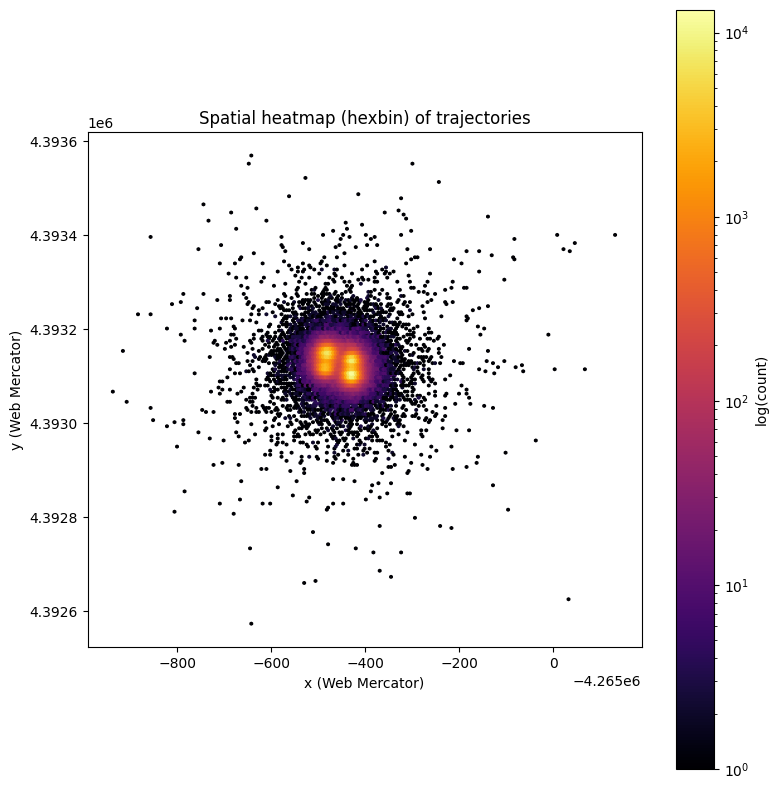

In [23]:
import matplotlib.pyplot as plt
x = heatmap_df['x'].values
y = heatmap_df['y'].values

plt.figure(figsize=(8, 8))
hb = plt.hexbin(x, y, gridsize=200, cmap='inferno', mincnt=1, bins='log')
plt.xlabel('x (Web Mercator)')
plt.ylabel('y (Web Mercator)')
plt.title('Spatial heatmap (hexbin) of trajectories')
cb = plt.colorbar(hb)
cb.set_label('log(count)')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()